#                                                    XGBoost

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
import matplotlib.pyplot as plt
import gc

/home/shubham95pandey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading dataset
path = "mnt/ssd/kaggle-talkingdata2/competition_files/"

dtypes = {'ip'           : 'uint32',
          'app'          : 'uint16',
          'device'       : 'uint16',
          'os'           : 'uint16',
          'channel'      : 'uint16',
          'is_attributed': 'uint8' ,
          'click_id'     : 'uint32'
    
         }
print('loading train data...')

train_df = pd.read_csv(path+"train.csv", dtype = dtypes, usecols = ['ip','app','device','os','channel','click_time','is_attributed'])
# total observation : 184,903,891

loading train data...


In [3]:
# Getting Label
y = train_df['is_attributed']
train_df.drop(['is_attributed'], axis=1, inplace=True)

In [4]:
print('loading test data....')
test_df = pd.read_csv("testfolder/test.csv", dtype = dtypes , usecols =['ip','app','device','os','channel','click_time','click_id'])


loading test data....


In [5]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
test_df.drop(['click_id'], axis=1, inplace = True)

len_train =len(train_df)
train_df = train_df.append(test_df)

del test_df
gc.collect()

42

In [6]:
print('Extracting day and hour...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day']  = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df.drop(['click_time'], axis=1, inplace=True)
gc.collect()

Extracting day and hour...


21

In [7]:
test = train_df[len_train:]
train = train_df[:(len_train)]
gc.collect()

print("train size: ", len(train))
print("test size: ", len(test))

train size:  184903890
test size:  18790469


In [8]:
"""
XGBoost parameters tuning guide:
https://github.com/dmlc/xgboost/blob/master/doc/how_to/param_tuning.md
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
"""

params = {'eta': 0.6,
          'tree_method': "hist",       #Fast histogram optimized approximate greedy algorithm.
          'grow_policy': "lossguide",  #split at nodes with highest loss change
          'max_leaves' : 1400,         # Maximum number of nodes to be added .(for lossguide grow policy)
          'max_depth'  : 0,            # 0 means no limit (useful only for depth wise grow policy)
          'subsample'  : 0.9,
          'colsample_bytree':0.7,
          'colsample_bylevel':0.7,
          'min_child_weight':0,         #the larger the more conservative the algorithm will be
          'alpha':4,                    # L1 regularization on weights | default = 0| Large value == more conservative model
          'objective':'binary:logistic',
          'scale_pos_weight':99,         # because training data is extremely unbalanced
          'eval_metric' : 'auc',
          'nthread' : 8,
          'random_state' : 84,
          'silent': True
         }

In [9]:
#spliting data

x1, x2, y1, y2 =train_test_split(train, y, test_size=0.1, random_state =99)

del train
gc.collect()

11

In [10]:
# watch list to observe the change in error in training and hold out data
start_time = time.time()

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

model = xgb.train(params, xgb.DMatrix(x1, y1), 50, watchlist, maximize=True, early_stopping_rounds = 20, verbose_eval =1)

del x1, x2, y1, y2
gc.collect()

print('[{}]: Training time for Histogram Optimized XGBoost model'.format(time.time() - start_time))

[0]	train-auc:0.962028	valid-auc:0.961052
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.966182	valid-auc:0.965266
[2]	train-auc:0.967078	valid-auc:0.96605
[3]	train-auc:0.967629	valid-auc:0.966247
[4]	train-auc:0.970186	valid-auc:0.968337
[5]	train-auc:0.970791	valid-auc:0.96842
[6]	train-auc:0.972608	valid-auc:0.969331
[7]	train-auc:0.973275	valid-auc:0.96935
[8]	train-auc:0.973538	valid-auc:0.969653
[9]	train-auc:0.974817	valid-auc:0.970617
[10]	train-auc:0.97523	valid-auc:0.970323
[11]	train-auc:0.975724	valid-auc:0.969929
[12]	train-auc:0.975982	valid-auc:0.969786
[13]	train-auc:0.976125	valid-auc:0.96955
[14]	train-auc:0.976546	valid-auc:0.969765
[15]	train-auc:0.97693	valid-auc:0.96965
[16]	train-auc:0.976983	valid-auc:0.969312
[17]	train-auc:0.977276	valid-auc:0.969249
[18]	train-auc:0.977433	valid-auc:0.968862
[19]	train-auc:0.977448	valid-auc:0.96893
[20]	train-auc:

predicting....
Extraction feature importance matrix
Completed.....


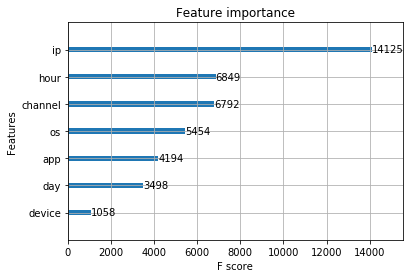

In [11]:
print("predicting....")
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('sub_xgb_hist_pos_weight.csv', index = False)


#Model evaluation

print("Extraction feature importance matrix")

plot_importance(model)
plt.gcf().savefig('xgb_fe.png')

print("Completed.....")